In [1]:
from typing import Literal, Tuple, List
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import norm, gaussian_kde, ks_1samp, uniform
from utils import *

# styling (optional)
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams.update({
    "font.size": 13,
    "axes.titlesize": 15,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
    "figure.titlesize": 17,
})

SEED = 400
random.seed(SEED)
np.random.seed(SEED)


## segmentation approach

In [2]:
def kcpd(
    x: np.ndarray,
    sigma: float | None = None,
    C: float = 0.06,
    beta: float | None = None,
) -> Tuple[List[int], float]:
    """
    Exact O(T^2) kernel segmentation (Section 3) for 1-D data.
    Returns change-points as end indices t in {1..T-1} and the objective value.

    kernel= "gaussian" or "rbf": K_ij = exp(-(x_i - x_j)^2 / (2 sigma^2)), sigma via median heuristic if None
    """
    x = np.asarray(x, dtype=float).ravel()
    T = x.size
    if T == 0:
        return [], 0.0

    # --- Gram matrix K ---
    diff2 = (x[:, None] - x[None, :]) ** 2
    if sigma is None:
        iu = np.triu_indices(T, 1)
        med = np.median(diff2[iu]) if iu[0].size else 1.0
        sigma = np.sqrt(max(med, 1e-12))
    K = np.exp(-diff2 / (2.0 * sigma * sigma))
    

    #Pre-computation of cumulative sums
    S = np.zeros((T + 1, T + 1), float)
    S[1:, 1:] = np.cumsum(np.cumsum(K, axis=0), axis=1)
    D = np.zeros(T + 1, float)
    D[1:] = np.cumsum(np.diag(K))

    if beta is None:
        beta = C * np.sqrt(T * max(np.log(max(T, 2)), 1.0))

    # --- DP ---
    DP = np.full(T + 1, np.inf)
    prev = np.full(T + 1, -1, int)
    DP[0] = -beta  # first segment not penalized

    for j in range(1, T + 1):
        best_val, best_t = np.inf, -1
        for t in range(0, j):
            i = t + 1
            # cost(i, j) = (D[j]-D[i-1]) - (1/n) * sum_{a=i..j, b=i..j} K_ab
            nseg = j - t
            diag_sum = D[j] - D[i - 1]
            block = S[j, j] - S[i - 1, j] - S[j, i - 1] + S[i - 1, i - 1]
            cost = diag_sum - block / nseg
            val = DP[t] + cost + beta
            if val < best_val:
                best_val, best_t = val, t
        DP[j], prev[j] = best_val, best_t

    # --- backtrack ---
    cps, cur = [], T
    while cur > 0:
        t = prev[cur]
        if t < 0:
            break
        if t > 0:
            cps.append(t)
        cur = t
    cps.sort()
    return cps, float(DP[T])


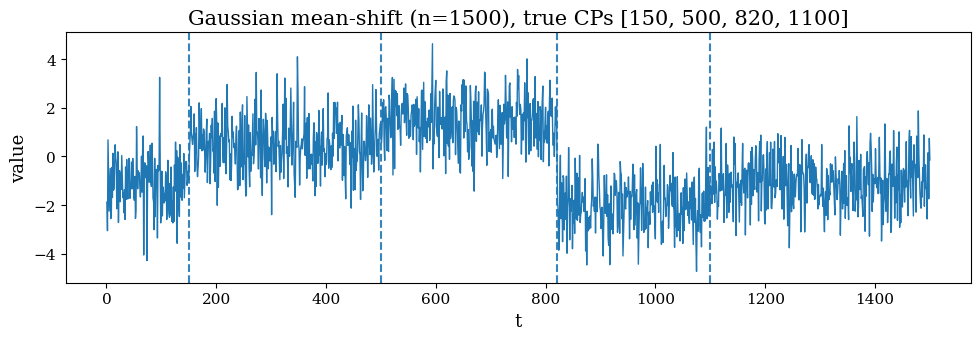

In [3]:
def generate_meanshift_1d(n: int, cps: list[int], means: list[float], sigma: float = 1.0, seed: int | None = None):
    rng = np.random.default_rng(seed)
    cps = sorted(int(t) for t in cps if 1 <= t < n)
    assert len(means) == len(cps) + 1, "len(means) must be #segments = len(cps)+1"
    seg_lengths = np.diff([0] + cps + [n])
    y = np.concatenate([rng.normal(m, sigma, L) for m, L in zip(means, seg_lengths)])
    return y, cps

# example
n = 1500
true_cps = [150, 500, 820, 1100]
means = [-1.0, 0.5, 1.5, -2.0,-1.0]
X, cps_true = generate_meanshift_1d(n, true_cps, means, sigma=1.0, seed=400)

t = np.arange(1, n + 1)
plt.figure(figsize=(10, 3.6))
plt.plot(t, X, lw=1.0)
for cp in cps_true:
    plt.axvline(cp, ls="--", alpha=0.9)
plt.title(f"Gaussian mean-shift (n={n}), true CPs {cps_true}")
plt.xlabel("t")
plt.ylabel("value")
plt.tight_layout()
plt.show()


In [4]:
X = X.reshape(-1, 1)

# Gaussian KCPD; tweak C (or pass beta) to control # of segments
cps_hat, obj = kcpd(X, C=0.02)  
print("Estimated CPs:", cps_hat, "| objective:", obj)


Estimated CPs: [150, 497, 820, 1091] | objective: 396.80732590238324


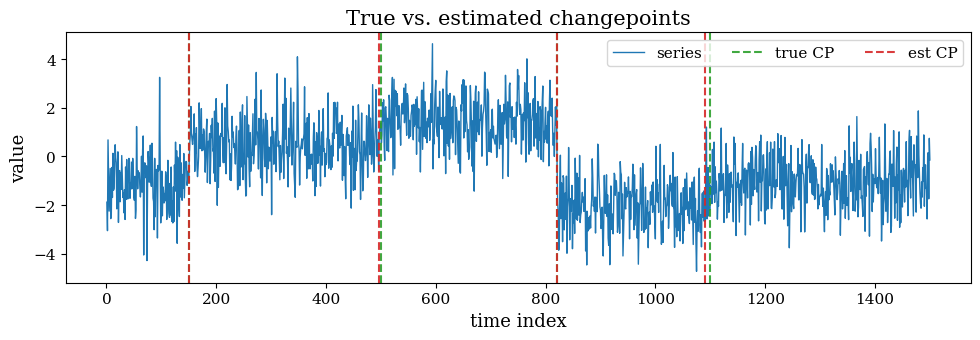

Estimated segments (1-based): [(1, 150), (151, 497), (498, 820), (821, 1091), (1092, 1500)]


In [5]:
import matplotlib.pyplot as plt

# plot series + CPs (true=green, est=red)
plt.figure(figsize=(10, 3.6))
plt.plot(t, X, lw=1.0, label="series")
for j, cp in enumerate(cps_true):
    plt.axvline(cp, ls="--", alpha=0.9, color="tab:green", label="true CP" if j == 0 else None)
for j, cp in enumerate(sorted(cps_hat)):
    plt.axvline(cp, ls="--", alpha=0.9, color="tab:red",   label="est CP"  if j == 0 else None)
plt.title("True vs. estimated changepoints")
plt.xlabel("time index"); plt.ylabel("value")
plt.legend(ncol=3)
plt.tight_layout()
plt.show()

# segments (1-based)
cps = sorted([c for c in cps_hat if 1 <= c < len(X)])
segments = list(zip([1] + [c+1 for c in cps], cps + [len(X)]))
print("Estimated segments (1-based):", segments)


## CONCH on top of it

In [6]:
def par_learned_loglik_score(x, t):
    
    x = np.asarray(x, dtype=float).reshape(-1)
    n = x.size
    
    # Prefix sums
    S = np.cumsum(x)
    Q = np.cumsum(x * x)
    S_total, Q_total = S[-1], Q[-1]

    t_vals = np.arange(1, n)
    num_Left, num_Right = t_vals, n - t_vals
    S_Left, Q_Left = S[t_vals - 1], Q[t_vals - 1]
    S_Right, Q_Right = S_total - S_Left, Q_total - Q_Left

    # log-likelihood ratio function
    LLR = -0.5 * ((Q_Left - (S_Left**2)/num_Left) + (Q_Right - (S_Right**2)/num_Right))

    t_hat = int(np.argmax(LLR))  
    return float(LLR[t - 1] - LLR[t_hat])

In [7]:
y = np.asarray(X, float).ravel()
n = y.size
cps = sorted(int(t) for t in cps_hat if 1 <= t < n)

# midpoints 
mids = [0]
if len(cps) >= 2:
    mids += [cps[i] + (cps[i+1] - cps[i]) // 2 for i in range(len(cps) - 1)]
elif len(cps) == 1:
    mids += [cps[0] // 2]
mids += [n]
mids = np.clip(np.unique(mids), 0, n).tolist()

wins = [(a, b) for a, b in zip(mids[:-1], mids[1:]) if b - a >= 2]

p_concat = np.full(n - 1, np.nan, float)
ci_union = set()

for a, b in wins:
    pvals = compute_p_values(
        y[a:b],
        score_fn=par_learned_loglik_score,
        nperm=300,
        random_state=42,
        n_jobs=-1,
        backend="loky",
        verbose=10,
    )
    ci_local = confidence_set(pvals, 0.05)
    ci_union.update(a + int(t) for t in ci_local)
    p_concat[a : b - 1] = pvals

ci_global_sorted = sorted(ci_union)

print("Windows [a,b):", wins)
print("Global CI (concatenated):", ci_global_sorted)


computing CONCH p-values:   0%|          | 0/322 [00:00<?, ?it/s]

computing CONCH p-values:   0%|          | 0/334 [00:00<?, ?it/s]

computing CONCH p-values:   0%|          | 0/296 [00:00<?, ?it/s]

computing CONCH p-values:   0%|          | 0/544 [00:00<?, ?it/s]

Windows [a,b): [(0, 323), (323, 658), (658, 955), (955, 1500)]
Global CI (concatenated): [145, 147, 148, 149, 150, 151, 152, 483, 484, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 510, 511, 513, 514, 515, 820, 821, 1084, 1087, 1088, 1089, 1090, 1091, 1092, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103]


## Visualization

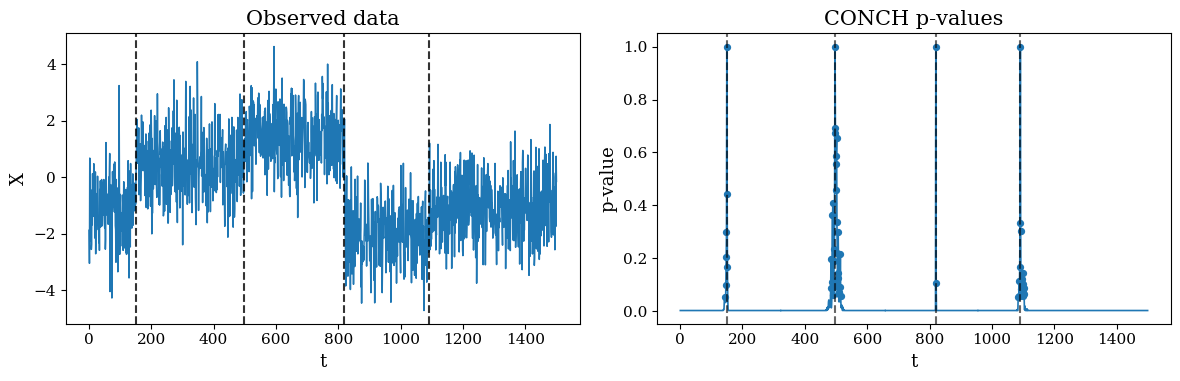

In [10]:
t = np.arange(1, n + 1)
t_p = np.arange(1, n)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))

ax0.plot(t, y, lw=1.1)
for cp in cps:
    ax0.axvline(cp, ls="--", color="black", alpha=0.8)
ax0.set_title("Observed data")
ax0.set_xlabel("t")
ax0.set_ylabel("X")

ax1.plot(t_p, p_concat, lw=1.2)
if len(ci_global_sorted) > 0:
    ax1.scatter(ci_global_sorted, p_concat[np.array(ci_global_sorted) - 1], s=18, marker="o")
for cp in cps:
    ax1.axvline(cp, ls="--", color="black", alpha=0.6)
ax1.set_title("CONCH p-values")
ax1.set_xlabel("t")
ax1.set_ylabel("p-value")

fig.tight_layout()
plt.savefig("../images/KCPD_CONCH_pvalue.pdf")
plt.show()
